# Setting up and Initialization

**Note:** Most of the times it is needed to reinitializate the enviorment to correctly execute the whole program due to problems on importing libraries. If after executing the first cell of the *Code* section (third cell from the beginning), any error appears, please, reinitializate the enviorment and execute everything again.

In [0]:
#Set up and import all libraries and utilities needed to execute the Pommerman project
import os
import sys
import numpy as np

#Download Pommerman enviorment from the repository
!git clone https://github.com/MultiAgentLearning/playground

os.chdir('playground')

!python setup.py install

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

!pip install emoji

# install gym
! pip install git+https://github.com/openai/gym

fatal: destination path 'playground' already exists and is not an empty directory.
running install
running bdist_egg
running egg_info
writing pommerman.egg-info/PKG-INFO
writing dependency_links to pommerman.egg-info/dependency_links.txt
writing entry points to pommerman.egg-info/entry_points.txt
writing requirements to pommerman.egg-info/requires.txt
writing top-level names to pommerman.egg-info/top_level.txt
reading manifest file 'pommerman.egg-info/SOURCES.txt'
writing manifest file 'pommerman.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pommerman
copying build/lib/pommerman/forward_model.py -> build/bdist.linux-x86_64/egg/pommerman
creating build/bdist.linux-x86_64/egg/pommerman/agents
copying build/lib/pommerman/agents/__init__.py -> build/bdist.linux-x86_64/egg/pommerman/agents
copying build/lib/pommerman/agents/player_agent.py -> build

In [0]:
#Check if gym library has been imported successfully
try: 
  import gym
  !pom_battle
except ImportError:
    #In case of error reinitiate the enviorment (check Note at the beginning)
    print("Please restart and run all.")

Import error NSDE! You will not be able to render --> Cannot connect to "None"
/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
Starting the Game.
Final Result:  {'result': <Result.Win: 0>, 'winners': [1]}
Game Time:  1.4469943046569824


# CODE

Code developed to train Pommerman agents.

In [0]:
# Import more needed libraries
from pommerman.agents import SimpleAgent, RandomAgent, PlayerAgent
from pommerman.configs import ffa_v0_fast_env
from pommerman.envs.v0 import Pomme
from pommerman.characters import Bomber
from pommerman import utility

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym

# Instantiate the environment
config = ffa_v0_fast_env()
env = Pomme(**config["env_kwargs"])

#CUDA
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
print("Using device:", device)

Import error NSDE! You will not be able to render --> Cannot connect to "None"
Using device: cuda:0


In [0]:
class QNetwork(nn.Module):
    """Q-network class (Q-Network implementation)"""
    """It contains all the structure described on Model A"""

    #Constructor
    def __init__(self, n_inputs, n_outputs, learning_rate):
        super(QNetwork, self).__init__()
        # Output layer
        self.out = nn.Linear(n_inputs, n_outputs, bias=False)
        torch.nn.init.uniform_(self.out.weight, 0, 0.01)
        
        # SGD optimizer
        self.optimizer = optim.SGD(self.parameters(), lr=learning_rate) # no momentum=0.3
     
    #Forward pass
    def forward(self, x):
        x = self.out(x)
        return x
    
    #Loss
    def loss(self, q_outputs, q_targets):
        return torch.sum(torch.pow(q_targets - q_outputs, 2))
      
def one_hot(i, l):
    """One-hot encoder for groups of observations"""
    a = np.zeros((len(i), l))
    a[range(len(i)), i] = 1
    return a
  
def check_lists(b,p,o1,o2,o3):
    killer = 0
    suicide = False
    if(b == p):
        suicide = True
    if(b == o1):
        killer += 1
    if(b == o2):
        killer += 1
    if(b == o3):
        killer += 1
    return killer, suicide
  

def featurize(obs):
    """Define observations and prepares it for the next step"""
    
    # Different elements of the observation
    position = obs["position"]
    
    # Scope agent view for board
    scopeSize = 5
    padSize = scopeSize - 1
    outOfBoundsType = 14
    board = obs["board"]
    bPaddingSize = 11 + (padSize * 2)
    paddedBoard = np.full((bPaddingSize, bPaddingSize), outOfBoundsType, dtype=int)
    paddedBoard[padSize : board.shape[0] + padSize, padSize : board.shape[1] + padSize] = board
    (r, c) = position
    (rp, cp) = (r + padSize, c + padSize)
    scopedBoard = paddedBoard[r : rp + padSize + 1, c : cp + padSize + 1].reshape(-1)
    
    # Scope agent view for bomb blast strength
    bomb_blast_strength = obs["bomb_blast_strength"]
    paddedBombBlastStrength = np.zeros((bPaddingSize, bPaddingSize), dtype=int)
    paddedBombBlastStrength[padSize : bomb_blast_strength.shape[0] + padSize, padSize : bomb_blast_strength.shape[1] + padSize] = bomb_blast_strength
    scopedBombBlastStrength = paddedBombBlastStrength[r : rp + padSize + 1, c : cp + padSize + 1].reshape(-1)
    
    # Scope agent view for bomb life
    bomb_life = obs["bomb_life"]
    paddedBombLife = np.zeros((bPaddingSize, bPaddingSize), dtype=int)
    paddedBombLife[padSize : bomb_life.shape[0] + padSize, padSize : bomb_life.shape[1] + padSize] = bomb_life
    scopedBombLife = paddedBombLife[r : rp + padSize + 1, c : cp + padSize + 1].reshape(-1)
    
    #Other elements
    ammo = [obs["ammo"]]
    blast_strength = [obs["blast_strength"]]
    can_kick =[obs["can_kick"]]
    actionlist = obs['actionlist']
    
    teammate = obs["teammate"]
    if teammate is not None:
        teammate = teammate.value
    else:
        teammate = -1
    teammate = [teammate]

    enemies = obs["enemies"]
    enemies = [e.value for e in enemies]
    if len(enemies) < 3:
        enemies = enemies + [-1]*(3 - len(enemies))
    enemies = enemies

    #Create array of observations prepared for the next step
    output = []
    elements = [scopedBoard, scopedBombBlastStrength, scopedBombLife, position, ammo, blast_strength, can_kick, actionlist]
    sizes    = [15, 12, 11, 11, 11, 12, 2, 7]
    
    for (i, n) in zip(elements,sizes):
        
        if isinstance(i, tuple) or isinstance(i, list):
          i = [int(i[index]) for index in range(len(i))]
        else:
          i = i.astype(int)
        output = np.concatenate((output, one_hot(i,n).reshape(-1)), axis=0)
    out = np.array([output])
    return out

In [0]:
class BaseAgent:
    """Parent abstract Agent."""
    """This is the base abstraction for agents in pommerman."""
    """All agents should inherent from this class"""

    def __init__(self, character=Bomber):
        self._character = character

    def __getattr__(self, attr):
        return getattr(self._character, attr)

    def act(self, obs, action_space):
        raise NotImplementedError()

    def episode_end(self, reward):
        """This is called at the end of the episode to let the agent know that
        the episode has ended and what is the reward."""
        pass

    def init_agent(self, id, game_type):
        self._character = self._character(id, game_type)

    @staticmethod
    def has_user_input():
        return False

    def shutdown(self):
        pass

In [0]:
class OwnAgent(BaseAgent):
    """Implementation of our own agent, based on Model A"""
    #Constructor
    def __init__(self, character=Bomber):
        self._character = character
        #Dimension of the input
        self.n_inputs = 3195
        #Dimension of the output layer
        self.n_outputs = 6
        #self.n_inputs_size = 14
        #Learning rate
        self.learning_rate = 0.0005
        #Discount rate
        self.gamma = 0.99
        #Action list
        self.actionlist = [6,6,6,6,6,6,6,6,6,6]
        
        #Q-network
        self.qnet = QNetwork(self.n_inputs, self.n_outputs, self.learning_rate)
        # GPU
        if use_cuda:
          self.qnet.cuda()
        
        self.Q = 0
        self.Q1 = 0
        
        #self.master = SimpleAgent(config["agent"](agent_id, config["game_type"]))
    
    def act(self, obs, action_space):
        obs['actionlist'] = self.actionlist
        # 1- do foward pass of current state to compute Q-values for all actions
        self.qnet.optimizer.zero_grad()
        self.Q = self.qnet(torch.from_numpy(featurize(obs)).float().to(device))
        
        # 2- select action with epsilon-greedy strategy
        if np.random.rand() > epsilon:
          a = self.Q.argmax().item()  
        else:
          a = env.action_space.sample()
        #Save action chosen
        self.actionlist.insert(0,a)
        del self.actionlist[10]
        return a
     
    # After step function
    def afterstep(self, s1, r, a):
        s1['actionlist'] = self.actionlist
        # 3- do forward pass for the next state
        with torch.no_grad():
            self.Q1 = self.qnet(torch.from_numpy(featurize(s1)).float().to(device))

        # 4. set Q-target
        q_target = self.Q.clone()
        #Update value of the current action
        q_target[0, a] = r + self.gamma * self.Q1.max().item() * (not done)

        # 5. update network weights
        loss = self.qnet.loss(self.Q, q_target)
        #loss.backward(retain_graph=True)
        loss.backward()
        self.qnet.optimizer.step()
        return loss

In [0]:
# Pommerman agents setup
# Own agent ready to play against 3 simple agents
agents = {}

agent_id=0; agents[agent_id] = RandomAgent(config["agent"](agent_id, config["game_type"]))
agent_id=1; agents[agent_id] = RandomAgent(config["agent"](agent_id, config["game_type"]))  
agent_id=2; agents[agent_id] = RandomAgent(config["agent"](agent_id, config["game_type"])) 
agent_id=3; agents[agent_id] = OwnAgent(config["agent"](agent_id, config["game_type"]))

env.set_agents(list(agents.values()))
env.set_init_game_state(None)

In [0]:
class RewardsShaper:
    """Implementation of our defined reward shapping"""
    def __init__(self):
        self.bomb_list = {'own_bombs':{},'other_bombs':{}}
        

    def run(self, s, a, s1, done, info):
        reward = 0
        lookup = ['Stop', 'Up', 'Down', 'Left', 'Right', 'Bomb']
        
        a = a[3]
        
        p  = s[3]['position']
        p1 = s1[3]['position']
        o1 = s[0]['position']
        o2 = s[1]['position']
        o3 = s[2]['position']
        
        # Update bomb_list
        if(a == 5 and s1[3]['bomb_life'][ p[0] ][ p[1] ] == 9):
          
          self.bomb_list['own_bombs'][str(p[0])+","+str(p[1])] = {
              'position': [ p[0], p[1] ]
          }
        
        suicide = False
        killer = 0
        
        # Check if own bomb goes off
        for key, value in self.bomb_list['own_bombs'].items():
          b = (value['position'][0], value['position'][1])
          
          if(s1[3]['bomb_life'][ b[0] ][ b[1] ] < 2): # Bombs goes off at bomb_life = 1
            del self.bomb_list['own_bombs'][key]
            killer, suicide = check_lists(b, p, o1, o2, o3) # heart of the fire
            
            for i in range(10):
              if(b[0]-i>-1):
                cur_pos = [b[0]-i , b[1]]
                if(s[3]['board'][ cur_pos[0] ][ cur_pos[1] ] == 4): # Fire
                  killer, suicide = check_lists(cur_pos, p, o1, o2, o3)
                else:
                  break
              else:
                  break
                
            for i in range(10):
              if(b[0]+i<11):
                cur_pos = [b[0]+i , b[1]]
                if(s[3]['board'][ cur_pos[0] ][ cur_pos[1] ] == 4): 
                  killer, suicide = check_lists(cur_pos, p, o1, o2, o3)
                else:
                  break
              else:
                  break
                
            for i in range(10):
              if(b[1]-i>-1):
                cur_pos = [b[0] , b[1]-i]
                if(s[3]['board'][ cur_pos[0] ][ cur_pos[1] ] == 4): 
                  killer, suicide = check_lists(cur_pos, p, o1, o2, o3)
                else:
                  break
              else:
                  break
                
            for i in range(10):
              if(b[1]+i<11):
                cur_pos = [b[0] , b[1]+i]
                if(s[3]['board'][ cur_pos[0] ][ cur_pos[1] ] == 4): 
                  killer, suicide = check_lists(cur_pos, p, o1, o2, o3)
                else:
                  break
              else:
                break
            break
        
        if (suicide==True):
          print("Suicide")
          reward -= 3
        
        reward += 10*killer
        
        # Reward: Lay bombs and have ammo
        if(a == 5 and s[3]["ammo"]>0):
            reward += 0.1
            
        # Penalty: Lay bombs and have no ammo
        elif(a == 5 and s[3]["ammo"]==0):
            reward -= 0.1

        # Penalty: Go into fire! or stone, wood or off the board
        y, x = s[3]["position"]

        if(a==3): # action is go left
          if(p[1]-1>=0): # is on the board
            next_pos = s[3]['board'][ p[0] ][ p[1]-1 ]
            if(next_pos == 4): # fire
              reward -= 1
            elif(next_pos == 1 or next_pos == 2): # stone or wood
              reward -= 0.1
          else: # on not the board
            reward -= 0.1

        elif(a==4): # action is go right
          if(p[1]+1<11): # is on the board
            next_pos = s[3]['board'][ p[0] ][ p[1]+1 ]
            if(next_pos == 4): # and fire to the right
              reward -= 1
            elif(next_pos == 1 or next_pos == 2): # stone or wood
              reward -= 0.1
          else: # not the board
            reward -= 0.1
            
        elif(a==2): # action is go down
          if(p[0]-1>=0): # is on the board
            next_pos = s[3]['board'][ p[0]-1 ][ p[1] ]
            if(next_pos == 4): # and fire under
              reward -= 1
            elif(next_pos == 1 or next_pos == 2): # stone or wood
              reward -= 0.1
          else: # not the board
            reward -= 0.1

        elif(a==1): # action is go up
          if(p[0]+1<11): # is on the board
            next_pos = s[3]['board'][ p[0]+1 ][ p[1] ]
            if(next_pos == 4): # and fire over
              reward -= 1
            elif(next_pos == 1 or next_pos == 2): # stone or wood
              reward -= 0.1
          else: # not the board
            reward -= 0.1

        # Penalty: Don't stand still for more than 10 turns
        index = 0
        counter = 0
        for i in range(len(ep_actions)):
          counter+=1
          if(ep_actions[-counter])!=0:
            counter-=1
            break
        
        if(counter>9):
          reward += (9-counter)

        return reward

# Load model file

It is possible to load previous trainned models.

In [0]:
from google.colab import files
import io
uploaded = files.upload()


KeyboardInterrupt: ignored

In [0]:
buffer = io.BytesIO(uploaded["simple_modelA.pth.tar"])
agents[3].qnet.load_state_dict(torch.load(buffer))

# START TRAINING

Train our own agent

In [0]:
# train Q-network
%%time

env.seed(0)

num_episodes = 1000
episode_limit = 1000
val_freq = 100 # validation frequency

try:
    epsilon = 1.0
    shapedreward = RewardsShaper()
    rewards, lengths, losses, epsilons, wins, actionlog = [], [], [], [], [0] * num_episodes, []
    print('start training')
    for i in range(num_episodes):
        # init new episode
        s, ep_reward, ep_loss, ep_actions = env.reset(), 0, 0, []
        q_values = []
        r = 0
        
        # Maximum rounds per episode
        for j in range(episode_limit):
            actions = env.act(s)
            s1, r, done, info = env.step(actions)
            
            #Check if our agent is still alive
            if(13 in s[3]['alive']):
                ep_actions.append(actions[3])
                
                shaped = shapedreward.run(s, actions, s1, done, info)
                ep_reward += shaped
                r[3] += shaped
                loss = agents[3].afterstep(s1[3], r[3], actions[3])

                ep_loss += loss.item()
                q_values.append(agents[3].Q)
            else:
              done = True  
              
            s = s1
            if done: break
              
        # Episode is finished
        if("winners" in info):
          if(3 in info["winners"]):
            ep_reward += 1
            wins[i] = 1
            print("w",end="")
          else:
            ep_reward -= 1
            print(".",end="")
        else:
            ep_reward -= 1
            print(".",end="")
        
        # Bookkeeping
        epsilon *= num_episodes/(i/(num_episodes/20)+num_episodes) # decrease epsilon
        epsilons.append(epsilon); rewards.append(ep_reward); lengths.append(len(ep_actions))
        losses.append(ep_loss); actionlog.append(ep_actions)
        if (i+1) % val_freq == 0: print('{:5d} mean training reward: {:5.2f}'.format(i+1, np.mean(rewards[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

start training
....Suicide
..w.w..Suicide
..w.....Suicide
.Suicide
.ww..w..w.w.wSuicide
.w...Suicide
www.www...w.w.www..w...........w...Suicide
...w...w..........Suicide
.........  100 mean training reward: -1.67
...Suicide
..Suicide
..Suicide
...w.Suicide
.Suicide
....ww.w.ww..w.wSuicide
.....Suicide
w......w..Suicide
.w...w.....Suicide
.wSuicide
.Suicide
..w.........w..w..Suicide
..Suicide
.............w.w....Suicide
..  200 mean training reward: -2.08
.....wSuicide
........Suicide
.w.....w....Suicide
...Suicide
.www..w...........wSuicide
.Suicide
..w.....Suicide
.wwwwww............wSuicide
.....Suicide
.wSuicide
wSuicide
.wwww........Suicide
.w  300 mean training reward: -1.67
Suicide
.....wSuicide
....ww.wwSuicide
.w.wwwwSuicide
..w.w....w.ww.........Suicide
.Suicide
w.wwSuicide
.Suicide
......Suicide
.wSuicide
.Suicide
.......wwwSuicide
Suicide
.wSuicide
.Suicide
..Suicide
...wwSuicide
.......Suicide
..Suicide
.Suicide
...w..www.w  400 mean training reward: -1.72
Suicide
Suicide
.

In [0]:
## if there is an error resize the wins and num_episodes to still be able to pring
if(len(rewards)!=num_episodes):
  new_lenght = len(rewards)
  num_episodes = new_lenght
  wins = wins[:new_lenght]

# Plot results

Visualize training statistics

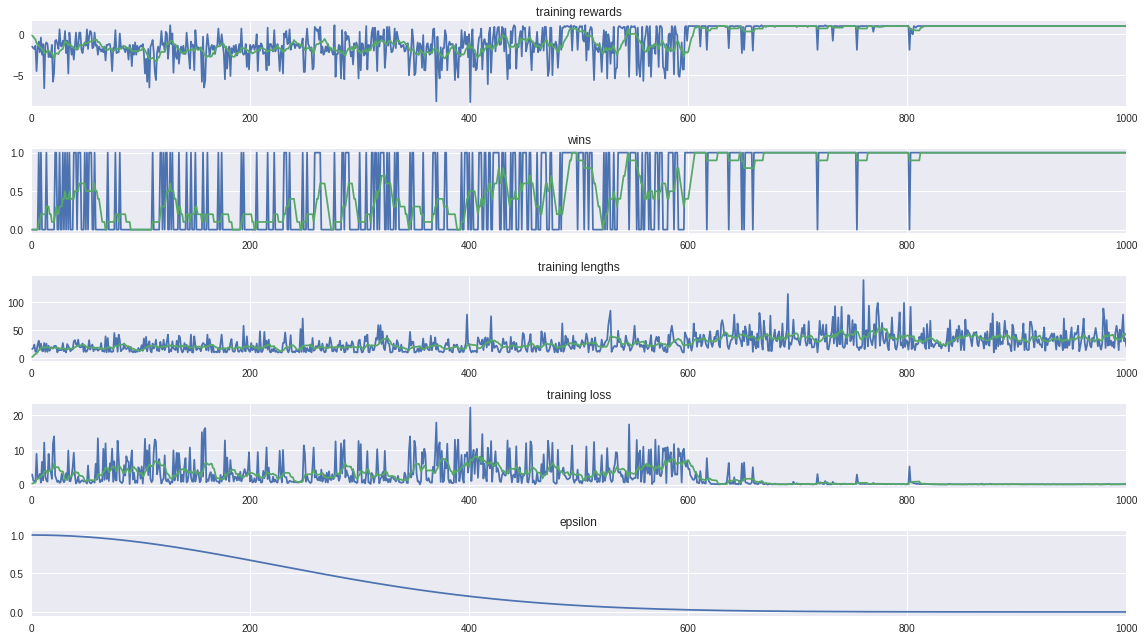

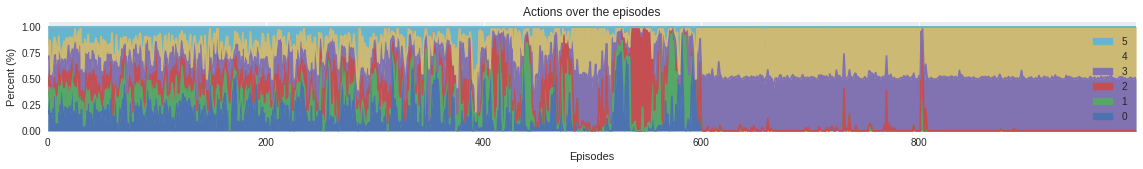

In [0]:
# Plot training statistics
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16, 9))
#Plot training rewards
plt.subplot(511)
plt.title('training rewards')
plt.plot(range(1, num_episodes+1), rewards)
plt.plot(range(1, num_episodes+1), moving_average(rewards))
plt.xlim([0, num_episodes])
#Plot wins
plt.subplot(512)
plt.title('wins')
plt.plot(range(1, num_episodes+1), wins)
plt.plot(range(1, num_episodes+1), moving_average(wins))
plt.xlim([0, num_episodes])
#Plot training lengths
plt.subplot(513)
plt.title('training lengths')
plt.plot(range(1, num_episodes+1), lengths)
plt.plot(range(1, num_episodes+1), moving_average(lengths))
plt.xlim([0, num_episodes])
#Plot training loss
plt.subplot(514)
plt.title('training loss')
plt.plot(range(1, num_episodes+1), losses)
plt.plot(range(1, num_episodes+1), moving_average(losses))
plt.xlim([0, num_episodes])
#Plot epsilon
plt.subplot(515)
plt.title('epsilon')
plt.plot(range(1, num_episodes+1), epsilons)
plt.xlim([0, num_episodes])

plt.tight_layout(); plt.show()

#Plot actions done in each episode
import pandas as pd
from collections import Counter

size = len(actionlog)
y = np.zeros((size,6))

for i in range(size):
  n = Counter(actionlog[i])
  for j in range(6):
    y[i][j] = n[j]
    
x = np.arange(size)
df = pd.DataFrame(y, index=x)

df = df.divide(df.sum(axis=1), axis=0)
ax = df.plot(kind='area', stacked=True, title='Actions over the episodes', figsize=(19.5, 2),legend = 'reverse')

ax.set_xlabel('Episodes'); ax.set_ylabel('Percent (%)')
ax.margins(0, 0) # Set margins to avoid "whitespace"

plt.show()

# Save file

Save trainned models and download it in a file

In [0]:
from google.colab import files
torch.save(agents[3].qnet.state_dict(), "simple_modelA.pth.tar")
files.download( "simple_modelA.pth.tar" ) 

# Animation

Use emojii render to visualize a game with the pre-trainned agent.

In [0]:
lookup = ['Stop', 'Up', 'Down', 'Left', 'Right', 'Bomb']

In [0]:
import emoji

def myRender(stage):
  for i in stage:
    for j in i:
      if(j==0): # free ground
        j = emoji.emojize(":white_question_mark:")
        #j = emoji.emojize(":white_large_square:")
      elif(j==1): # stone wall
        j = emoji.emojize(":mountain:")
      elif(j==2): # wooden wall
        j = emoji.emojize(":seedling:")
      elif(j==3): # bomb
        j = emoji.emojize(":bomb:")
      elif(j==4): # fire     
        j = emoji.emojize(":fire:")
      # 5 is fog
      
      #power ups
      elif(j==6): # extra bombs item     
        j = emoji.emojize(":pistol:")
      elif(j==7): # extra firepower     
        j = emoji.emojize(":collision:")
      elif(j==8): # kick     
        j = emoji.emojize(":running_shoe:")
      
        
      elif(j==10 or j==11 or j==12): #opponent
        j = emoji.emojize(":smiling_face_with_horns:")
      elif(j==13): #our agent
        j = emoji.emojize(":smiling_face_with_sunglasses:")

      print(j, end = "")
    print("")    

this_stage = s[3]['board']
myRender(this_stage)

In [0]:
from IPython.display import clear_output
import time

num_episodes = 1
shapedreward = RewardsShaper()

rewards, lengths, losses, epsilons, wins, actionlog = [], [], [], [], [0] * num_episodes, []
for i in range(num_episodes):
    # init new episode
    s, ep_reward, ep_loss, ep_actions = env.reset(), 0, 0, []
    q_values = []
    r = 0
    
    

    for j in range(episode_limit):
        actions = env.act(s)
        s1, r, done, info = env.step(actions)
        
        
        clear_output()
        print()
        myRender(s[3]['board'])
        print()
        time.sleep(1.5)      
        
        if(13 in s[3]['alive']):
            shaped = shapedreward.run(s, actions, s1, done, info)
            ep_reward += shaped
            r[3] += shaped
            loss = agents[3].afterstep(s1[3], r[3], actions[3])

            ep_loss += loss.item()
            q_values.append(agents[3].Q)
        else:
          done = True
          
    # episode is finished 
    if("winners" in info):
      if(3 in info["winners"]):
        ep_reward += 1
        wins[i] = 1
      else:
        ep_reward -= 1

    print(".",end="")
    